In [1]:
pip install lmfit fredapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import yfinance as yfin
import math
from datetime import date
from matplotlib.gridspec import GridSpec
from numpy import linalg as LA
from scipy.interpolate import CubicSpline
from lmfit import Model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from fredapi import Fred
sns.set()
pd.options.display.float_format = "{:,.6f}".format

**Task 2:**
1.   Pick government securities from a country. The country selected should be one of the countries from your group so that you can fit a Nelson-Siegel model.
2.   Be sure to pick maturities ranging from short-term to long-term (e.g. 6 month maturity to 20 or 30 year maturities).
3.   Fit a Nelson-Siegel model.
4.   Fit a Cubic-Spline model.
5.   Compare the models in terms of 1) fit and 2) interpretation.
6.   Be sure to specify at the levels of model parameters (ex. Alpha1).
7.   In Module 2 Lesson 4 (‘Smoothing Data’), we said smoothing data can be unethical. If Nelson-Siegel is smoothing the yield curve, is this considered
 unethical? Why or why not?


In [3]:
#nelson siegel
def nelson_siegel(t, beta0, beta1, beta2, tau):
    t = np.array(t)
    t_tau = t / tau
    exp_term = np.exp(-t_tau)
    term1 = (1 - exp_term) / t_tau
    term1 = np.where(np.isnan(term1), 1.0, term1)
    term2 = term1 - exp_term

    return beta0 + beta1 * term1 + beta2 * term2



In [4]:
#treasury dara
def get_treasury_data():

    maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
    yields = np.array([5.45, 5.37, 5.15, 4.83, 4.58, 4.42, 4.40, 4.47, 4.80, 4.63])

    data = pd.DataFrame({
        'Maturity': maturities,
        'Yield': yields
    })

    return data

In [5]:
def main():
    treasury_data = get_treasury_data()
    print("US Treasury Yield Data:")
    print(treasury_data)

    maturities = treasury_data['Maturity'].values
    yields = treasury_data['Yield'].values

    ns_model = Model(nelson_siegel)
    params = ns_model.make_params(beta0=5.0, beta1=-1.0, beta2=-1.0, tau=1.5)

    params['beta0'].min = 0
    params['tau'].min = 0.1

    ns_result = ns_model.fit(yields, params, t=maturities)

    beta0 = ns_result.params['beta0'].value
    beta1 = ns_result.params['beta1'].value
    beta2 = ns_result.params['beta2'].value
    tau = ns_result.params['tau'].value


    print("\nNelson-Siegel Model Parameters:")
    print(f"beta0 (level): {beta0:.4f}")
    print(f"beta1 (slope): {beta1:.4f}")
    print(f"beta2 (curvature): {beta2:.4f}")
    print(f"tau (decay): {tau:.4f}")

    ns_fitted = nelson_siegel(maturities, beta0, beta1, beta2, tau)

    ns_residuals = yields - ns_fitted
    ns_rmse = np.sqrt(np.mean(ns_residuals**2))
    print(f"Nelson-Siegel RMSE: {ns_rmse:.6f}")

    #cubic spline
    cs_model = CubicSpline(maturities, yields)

    t_fine = np.linspace(min(maturities), max(maturities), 100)
    ns_curve = nelson_siegel(t_fine, beta0, beta1, beta2, tau)
    cs_curve = cs_model(t_fine)

    cs_fitted = cs_model(maturities)

    cs_residuals = yields - cs_fitted
    cs_rmse = np.sqrt(np.mean(cs_residuals**2))
    print(f"Cubic Spline RMSE: {cs_rmse:.6f}")

    plt.figure(figsize=(12, 8))


    #scatter plot
    plt.scatter(maturities, yields, color='black', label='Actual Yields', s=50)

    plt.plot(t_fine, ns_curve, 'r-', linewidth=2, label='Nelson-Siegel Model')
    plt.plot(t_fine, cs_curve, 'b-', linewidth=2, label='Cubic Spline Model')

    plt.title('US Treasury Yield Curve Modeling', fontsize=16)
    plt.xlabel('Maturity (years)', fontsize=14)
    plt.ylabel('Yield (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    plt.savefig('/yield_curve_comparison.png', dpi=300, bbox_inches='tight')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(maturities, ns_residuals, width=0.4, alpha=0.7, color='red')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Nelson-Siegel Model Residuals', fontsize=14)
    plt.xlabel('Maturity (years)', fontsize=12)
    plt.ylabel('Residual (Actual - Fitted)', fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 2, 2)
    plt.bar(maturities, cs_residuals, width=0.4, alpha=0.7, color='blue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Cubic Spline Model Residuals', fontsize=14)
    plt.xlabel('Maturity (years)', fontsize=12)
    plt.ylabel('Residual (Actual - Fitted)', fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.tight_layout()
    plt.savefig('residuals_comparison.png', dpi=300, bbox_inches='tight')

    results_df = pd.DataFrame({
        'Maturity': maturities,
        'Actual_Yield': yields,
        'Nelson_Siegel_Fitted': ns_fitted,
        'NS_Residual': ns_residuals,
        'Cubic_Spline_Fitted': cs_fitted,
        'CS_Residual': cs_residuals
    })


    results_df.to_csv('yield_curve_results.csv', index=False)

    return {
        'ns_params': {
            'beta0': beta0,
            'beta1': beta1,
            'beta2': beta2,
            'tau': tau
        },
        'ns_rmse': ns_rmse,
        'cs_rmse': cs_rmse
    }





US Treasury Yield Data:
   Maturity    Yield
0  0.250000 5.450000
1  0.500000 5.370000
2  1.000000 5.150000
3  2.000000 4.830000
4  3.000000 4.580000
5  5.000000 4.420000
6  7.000000 4.400000
7 10.000000 4.470000
8 20.000000 4.800000
9 30.000000 4.630000

Nelson-Siegel Model Parameters:
beta0 (level): 4.8981
beta1 (slope): 0.7492
beta2 (curvature): -2.6388
tau (decay): 2.5661
Nelson-Siegel RMSE: 0.061258
Cubic Spline RMSE: 0.000000


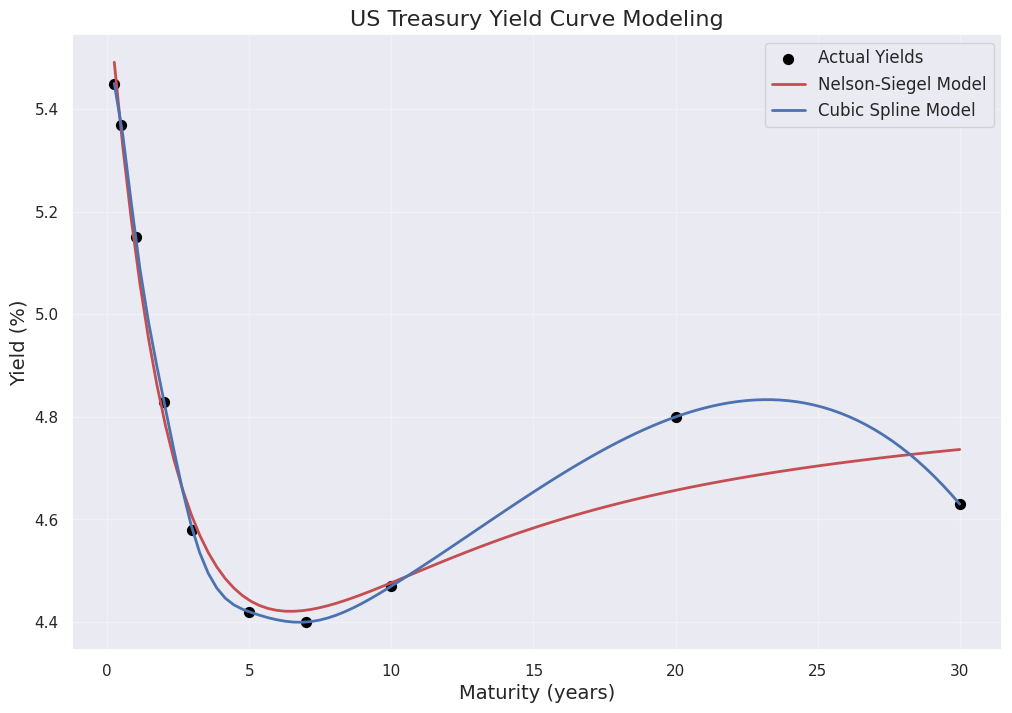

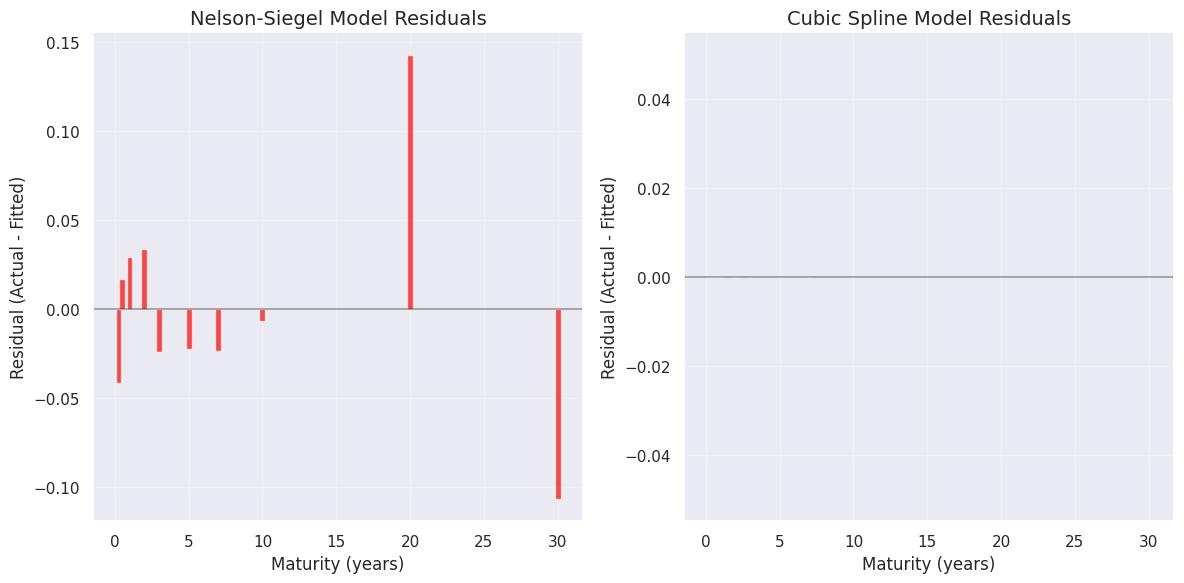

In [6]:
if __name__ == "__main__":
    main()

**Task 3 :**

1.   Generate 5 uncorrelated Gaussian random variables that simulate yield changes (they can be positive or negative with a mean close to 0 and a standard deviation that is small).
2.   Run a Principal Components using EITHER the correlation OR covariance matrix.
3.   Write a paragraph explaining how the variances of each component compare
with each other. In this paragraph, you will address the following question: how
much variance is explained by Component 1, Component 2, Component 3?
4.   Produce a screeplot (see https://en.wikipedia.org/wiki/Scree_plot) of the
variance explained for each component.
5.   Collect the daily closing yields for 5 government securities, say over 6 months.
6.   Be sure to compute the daily yield changes!
7.   Re-run the Principal Components using EITHER the correlation or covariance
matrix.
8.   How do the variances of each component compare? In other words, how much
variance is explained by Component 1, Component 2, Component 3, etc.?
9.  Produce a screeplot of the variance explained for each component.
10. How does the screeplot from the uncorrelated data compare with the screeplot
from the government data?



In [7]:
mean = 0.0       # Mean close to 0
std_dev = 0.01  # Small standard deviation
num_vars = 5     # Number of random variables
num_samples = 1000  # Number of samples

# Generate 5 uncorrelated Gaussian random variables
data = np.random.normal(mean, std_dev, (num_samples, num_vars))

print("Generated yield changes (in decimal):", data)
print("Approximate yield changes (in %):", np.round(data * 100, 2))

Generated yield changes (in decimal): [[-0.00829502  0.00325609 -0.00471429  0.00109842 -0.00678694]
 [-0.00081952 -0.00884235  0.01077236 -0.00410391 -0.00091933]
 [ 0.00179976  0.00258489 -0.00727286  0.0037133  -0.01013038]
 ...
 [-0.01535353  0.00132643  0.00717931  0.00891904 -0.01484333]
 [-0.00621605 -0.00396973  0.01301996  0.00024456  0.01247472]
 [-0.00349728 -0.0018786  -0.00815603  0.00708291 -0.00219673]]
Approximate yield changes (in %): [[-0.83  0.33 -0.47  0.11 -0.68]
 [-0.08 -0.88  1.08 -0.41 -0.09]
 [ 0.18  0.26 -0.73  0.37 -1.01]
 ...
 [-1.54  0.13  0.72  0.89 -1.48]
 [-0.62 -0.4   1.3   0.02  1.25]
 [-0.35 -0.19 -0.82  0.71 -0.22]]


In [8]:
# PCA using covariance matrix
pca = PCA()
pca.fit(data)  # Fit PCA to the data

# Explained variance ratio
print("Explained variance ratio (each PC):", pca.explained_variance_ratio_)

# Principal components (eigenvectors)
print("\nPrincipal Components (Eigenvectors):")
print(pca.components_)

Explained variance ratio (each PC): [0.22173838 0.21744172 0.19757403 0.18405455 0.17919133]

Principal Components (Eigenvectors):
[[ 0.53995921  0.69862455  0.04516356 -0.43732445  0.16454597]
 [-0.47819656 -0.00376493  0.72991869 -0.46576461  0.14695547]
 [-0.50991229  0.63750726 -0.1108664   0.17446968 -0.53929854]
 [ 0.18087241  0.23579581  0.54783724  0.74547788  0.23626806]
 [-0.43248899  0.22337054 -0.39084773  0.07505813  0.77760093]]


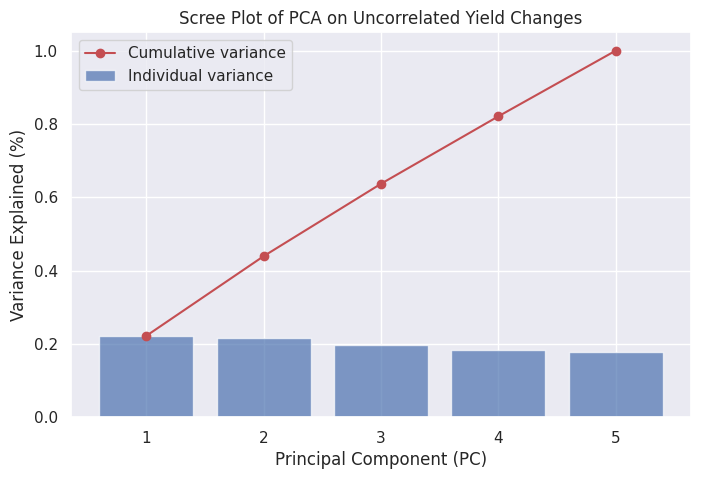

In [9]:
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), explained_variance, alpha=0.7, label='Individual variance')
plt.plot(range(1, 6), np.cumsum(explained_variance), 'ro-', label='Cumulative variance')

# Labels and title for the graph
plt.xlabel('Principal Component (PC)')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot of PCA on Uncorrelated Yield Changes')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

                 1Y       2Y       5Y      10Y      30Y
2023-10-02 5.490000 5.120000 4.720000 4.690000 4.810000
2023-10-03 5.490000 5.150000 4.800000 4.810000 4.950000
2023-10-04 5.420000 5.050000 4.720000 4.730000 4.870000
2023-10-05 5.390000 5.030000 4.680000 4.720000 4.890000
2023-10-06 5.430000 5.080000 4.750000 4.780000 4.950000


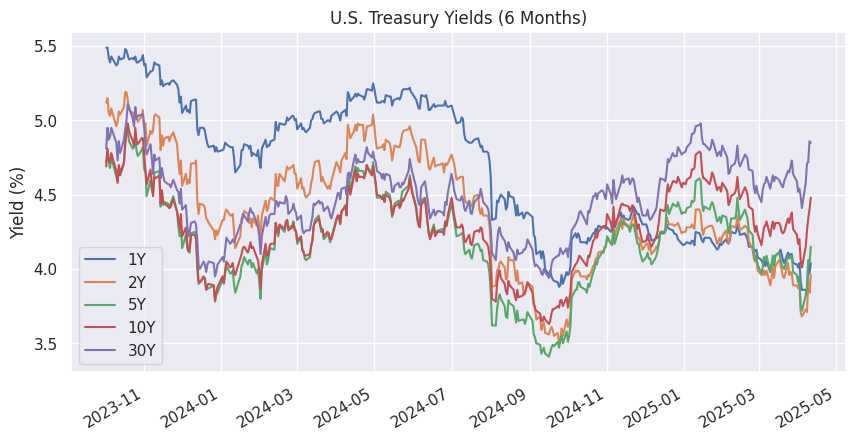

In [10]:
fred = Fred(api_key='483bbf3682adcea675af3ff51ca5e622')
series = {
    "1Y": "DGS1",   # 1-Year Treasury
    "2Y": "DGS2",   # 2-Year Treasury
    "5Y": "DGS5",   # 5-Year Treasury
    "10Y": "DGS10", # 10-Year Treasury
    "30Y": "DGS30"  # 30-Year Treasury
}

# Fetch data for the last 6 months
data = pd.DataFrame()
for tenor, series_id in series.items():
    data[tenor] = fred.get_series(series_id, observation_start='2023-10-01')

# Drop missing values and plot
data = data.dropna()
print(data.head())

# Plot yields
data.plot(figsize=(10, 5), title='U.S. Treasury Yields (6 Months)')
plt.ylabel('Yield (%)')
plt.show()

In [11]:
yield_changes = data.diff().dropna()
print("Yield Changes (Δy):\n", yield_changes.head())

Yield Changes (Δy):
                   1Y        2Y        5Y       10Y       30Y
2023-10-03  0.000000  0.030000  0.080000  0.120000  0.140000
2023-10-04 -0.070000 -0.100000 -0.080000 -0.080000 -0.080000
2023-10-05 -0.030000 -0.020000 -0.040000 -0.010000  0.020000
2023-10-06  0.040000  0.050000  0.070000  0.060000  0.060000
2023-10-10 -0.060000 -0.120000 -0.130000 -0.120000 -0.100000


In [12]:
# PCA on covariance matrix
pca_cov = PCA()
pca_cov.fit(yield_changes)  # Directly use yield changes

# Results
print("Explained variance (Covariance PCA):", pca_cov.explained_variance_ratio_)

Explained variance (Covariance PCA): [0.863711   0.11241131 0.01373186 0.00808696 0.00205887]


In [13]:
# Standardize data (mean=0, std=1)
scaler = StandardScaler()
yield_changes_std = scaler.fit_transform(yield_changes)

# PCA on correlation matrix
pca_corr = PCA()
pca_corr.fit(yield_changes_std)

# Results
print("Explained variance (Correlation PCA):", pca_corr.explained_variance_ratio_)

Explained variance (Correlation PCA): [0.84545681 0.12765981 0.01777984 0.00719963 0.00190392]


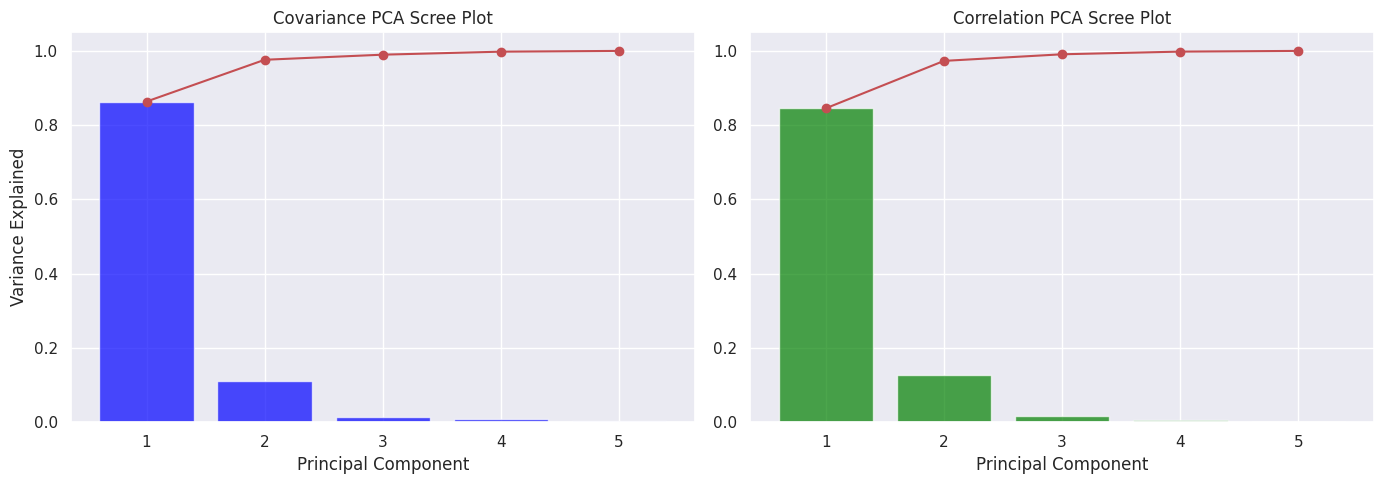

In [14]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot for Covariance PCA
ax1.bar(range(1, 6), pca_cov.explained_variance_ratio_, alpha=0.7, color='blue')
ax1.plot(range(1, 6), np.cumsum(pca_cov.explained_variance_ratio_), 'ro-')
ax1.set_title('Covariance PCA Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.grid(True)

# Scree plot for Correlation PCA
ax2.bar(range(1, 6), pca_corr.explained_variance_ratio_, alpha=0.7, color='green')
ax2.plot(range(1, 6), np.cumsum(pca_corr.explained_variance_ratio_), 'ro-')
ax2.set_title('Correlation PCA Scree Plot')
ax2.set_xlabel('Principal Component')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Task 4:**
Pick a sector ETF (in the US, for example, XLRE)


1.  Find the 30 largest holdings.
2.  Get at least 6 months of data (~ 120 data points).
3.  Compute the daily returns.
4.  Compute the covariance matrix.
5.  Compute the PCA.
6.  Compute the SVD.


In [16]:
# Downloading data from Yahoo finance or loading it locally
XLI=["GE" , "RTX" , "CAT" , "UBER" , "UNP" , "HON" , "ADP" , "DE" , "BA" , "ETN" , "LMT" , "WM", "GEV" , "UPS" , "TT" , "TDG" , "MMM" , "PH" , "NOC" , "CTAS" , "GD" , "ITW" , "EMR" , "CSX" , "CPRT" , "RSG" , "NSC" , "PCAR" , "JCI" , "FDX"]
start = datetime.date(2024, 7, 1)
end = datetime.date(2024, 12, 31)
if os.path.exists("XLI1.csv"):
    df=pd.read_csv("XLI1.csv",parse_dates=True, index_col=0)
else:
    df = yfin.download(XLI, start, end, auto_adjust = False)["Adj Close"]
    df = df[XLI]
    df.to_csv("XLI1.csv")
# Convert DataFrame index to timezone-aware (UTC)
df.index = df.index.tz_localize('UTC')
df.head(3)

,GE,RTX,CAT,UBER,UNP,HON,ADP,DE,BA,ETN,LMT,WM,GEV,UPS,TT,TDG,MMM,PH,NOC,CTAS,GD,ITW,EMR,CSX,CPRT,RSG,NSC,PCAR,JCI,FDX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00+00:00,157.915115,97.999565,325.379059,71.099998,221.170792,207.662872,232.039734,357.100555,186.699997,310.448761,457.584717,207.137817,167.394165,130.737457,320.572784,"1,186.512695",99.052544,497.270660,429.539490,172.885254,281.990723,229.313354,106.614883,33.225948,53.349998,190.782700,210.603195,98.121567,64.609703,294.154999
2024-07-02 00:00:00+00:00,160.378632,98.846176,324.073944,70.669998,221.800293,209.907349,232.984940,361.017883,185.419998,311.353149,456.858765,207.246658,169.682434,129.737350,324.034271,"1,210.551392",100.046906,506.223328,431.879730,175.435837,279.972778,231.376511,107.818672,33.394104,54.689999,191.591080,212.069138,97.225533,65.398590,293.701996
2024-07-03 00:00:00+00:00,161.918365,99.171028,326.891846,71.300003,221.869156,209.149353,233.260635,358.881165,184.309998,316.461548,457.182495,207.968903,172.550278,130.352798,330.478485,"1,215.666016",100.046906,508.893219,431.603271,175.019867,279.061737,231.848083,108.104828,33.186382,53.889999,191.967987,212.807022,98.275726,65.931099,289.260284


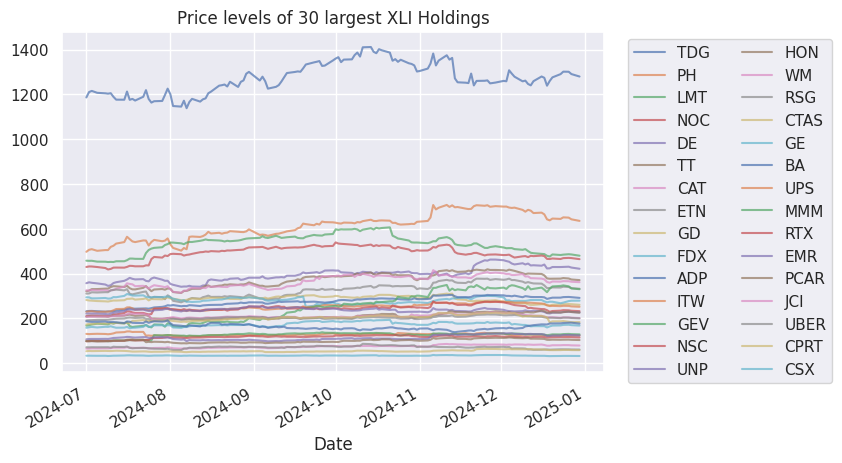

<Figure size 640x480 with 0 Axes>

In [17]:
df=df[df.mean().sort_values(ascending=False).index]
df.plot(figsize=(7, 5), title='Price levels of 30 largest XLI Holdings', alpha=0.7)
plt.legend(bbox_to_anchor=(1.03, 1),ncol=2)
plt.show()
plt.savefig('graphique.jpg')

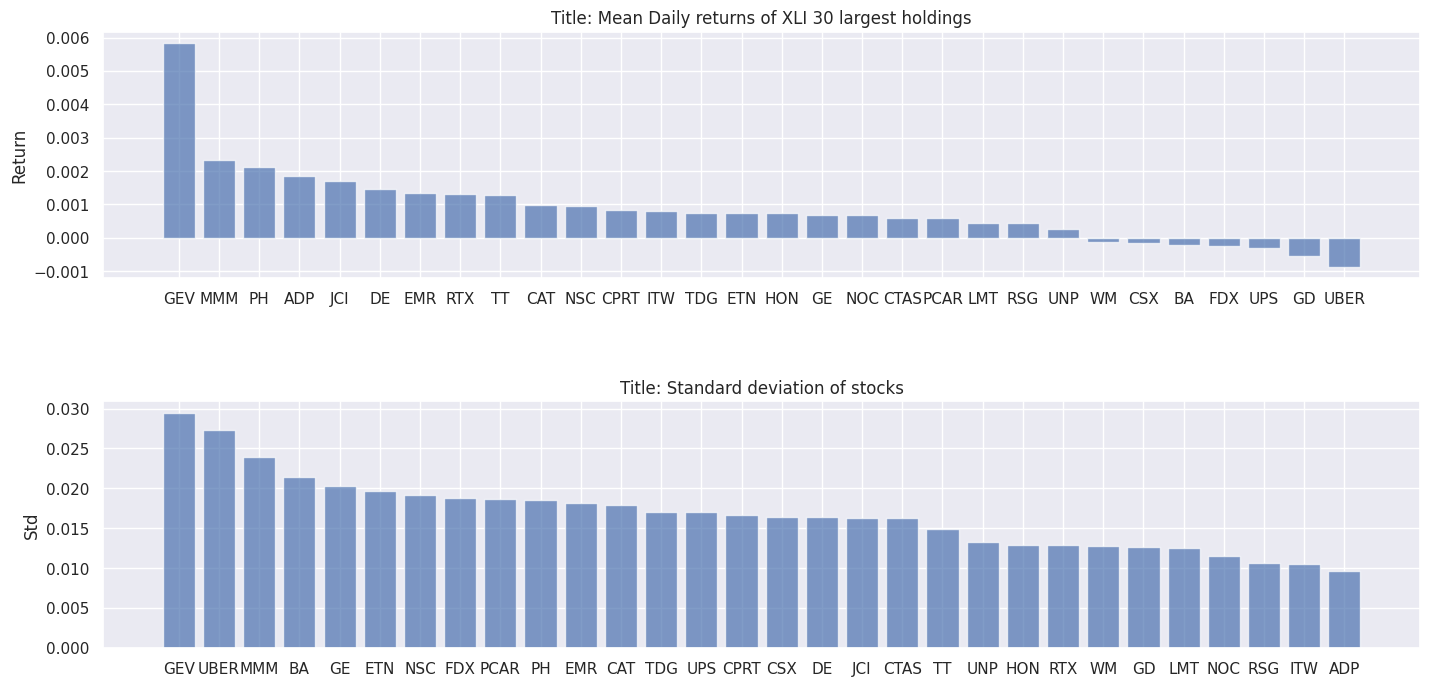

In [18]:
#calcul of precentage daily returns

r = df.pct_change().dropna()

#display of mean and standard deviation of returns

r_sorted_by_mean=r[r.mean().sort_values(ascending=False).index]
r_sorted_by_std=r[r.std().sort_values(ascending=False).index]

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (17,8))
ax1.bar(r_sorted_by_mean.columns,height = r_sorted_by_mean.mean(),alpha = 0.7)
ax1.set_title("Title: Mean Daily returns of XLI 30 largest holdings")
ax1.set_ylabel("Return")
ax2.bar(r_sorted_by_std.columns,height = r_sorted_by_std.std(), alpha = 0.7) # Make sure you
ax2.set_title("Title: Standard deviation of stocks")
ax2.set_ylabel("Std")
fig.subplots_adjust(wspace=0.5, hspace=0.5)
#plt.show()

In [19]:
def f(k):
    r2=r_sorted_by_std.iloc[:,k:k+5]*100
    return r2
ticker=[]
stds=[]
k=0
j=5
for i in range(6):
    r2=f(k)
    a= ', '.join(r2.columns)
    b=str(round(r2.iloc[:,[4]].std()[0],2))+' - '+str(round(r2.iloc[:,[0]].std()[0],2))+' %'
    k=k+5
    ticker.append(a)
    stds.append(b)

df_group = pd.DataFrame({'Group of stocks': ticker,'standard deviation': stds}, index=range(1,7))
df_group.head(6)

<ipython-input-19-e2d088a5da36>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b=str(round(r2.iloc[:,[4]].std()[0],2))+' - '+str(round(r2.iloc[:,[0]].std()[0],2))+' %'


,Group of stocks,standard deviation
1,"GEV, UBER, MMM, BA, GE",2.03 - 2.94 %
2,"ETN, NSC, FDX, PCAR, PH",1.85 - 1.96 %
3,"EMR, CAT, TDG, UPS, CPRT",1.67 - 1.82 %
4,"CSX, DE, JCI, CTAS, TT",1.49 - 1.65 %
5,"UNP, HON, RTX, WM, GD",1.27 - 1.32 %
6,"LMT, NOC, RSG, ITW, ADP",0.96 - 1.25 %


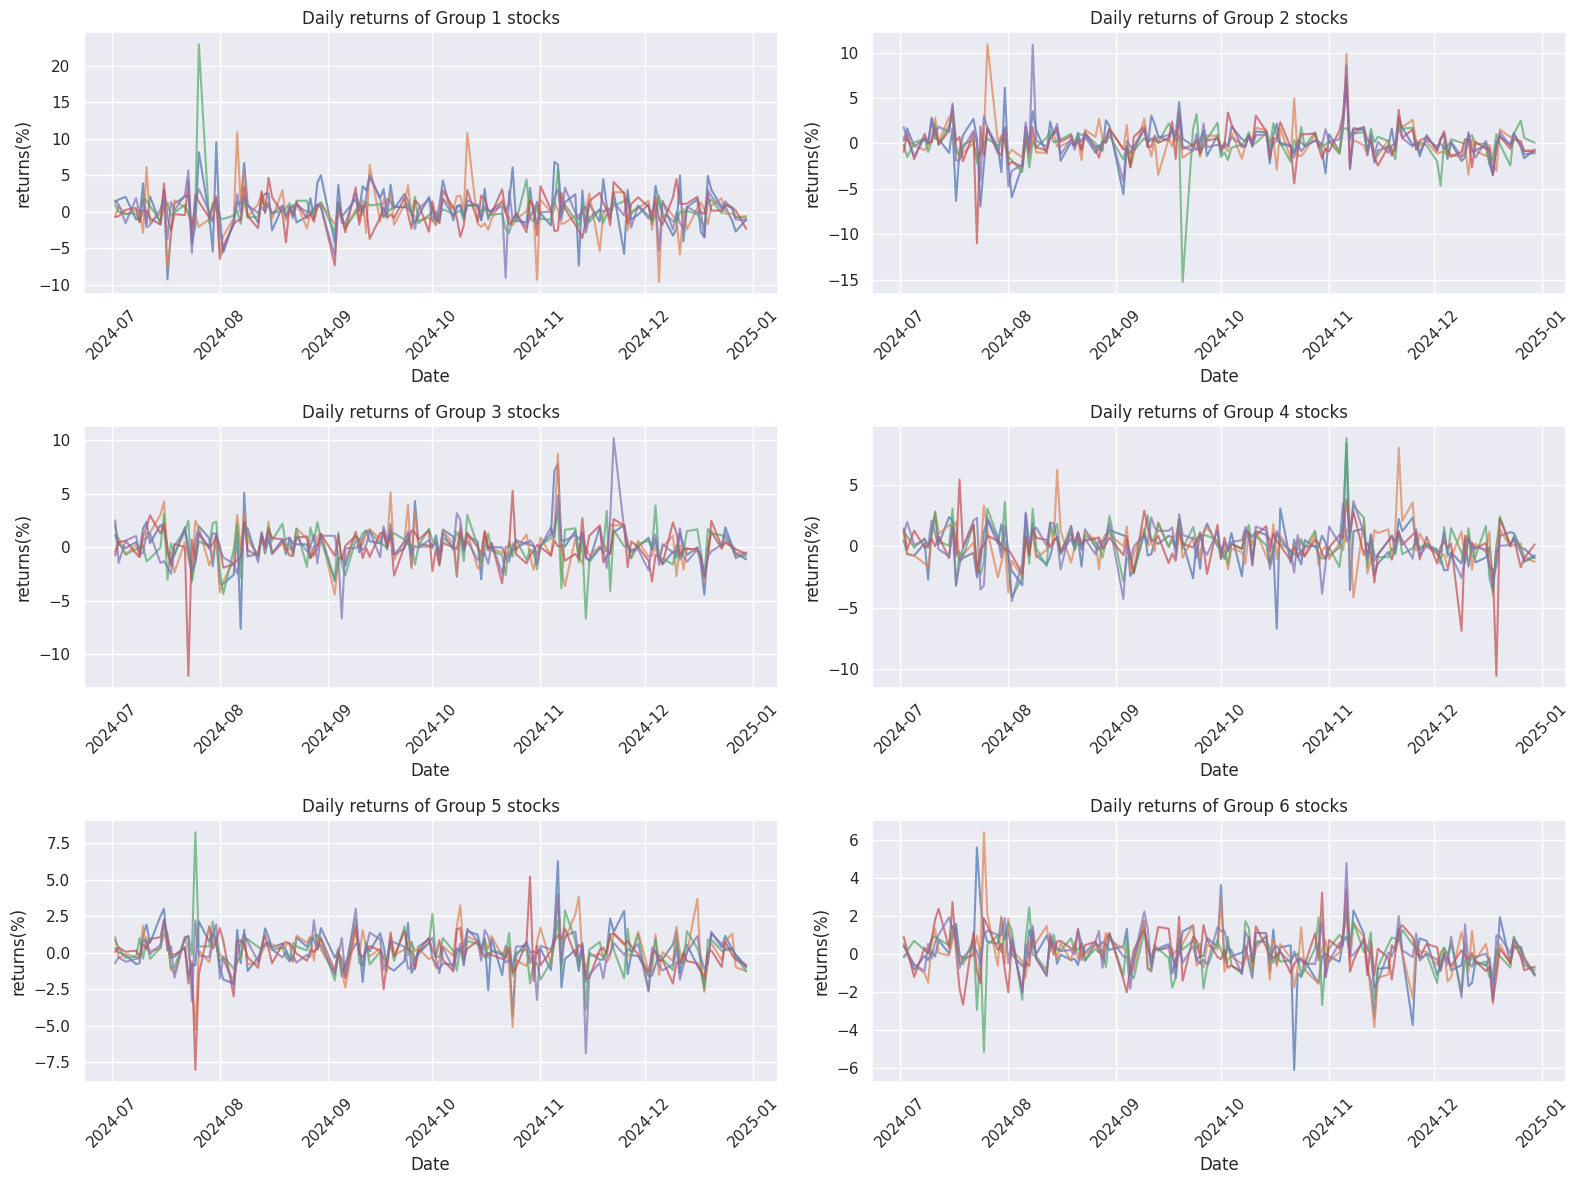

In [20]:

fig = plt.figure(figsize=(16, 12))

gs = GridSpec(3,2)

# First row, first column
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(r_sorted_by_std.iloc[:,0:5]*100, alpha=0.7)
ax1.set_title("Daily returns of Group 1 stocks")
ax1.set_xlabel('Date')
ax1.set_ylabel('returns(%)')
ax1.tick_params(axis='x', rotation=45)

# First row, second column
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(r_sorted_by_std.iloc[:,5:10]*100, alpha=0.7)
ax2.set_title("Daily returns of Group 2 stocks")
ax2.set_xlabel('Date')
ax2.set_ylabel('returns(%)')
ax2.tick_params(axis='x', rotation=45)

# Second row
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(r_sorted_by_std.iloc[:,10:15]*100, alpha=0.7)
ax3.set_title("Daily returns of Group 3 stocks")
ax3.set_xlabel('Date')
ax3.set_ylabel('returns(%)')
ax3.tick_params(axis='x', rotation=45)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(r_sorted_by_std.iloc[:,15:20]*100, alpha=0.7)
ax4.set_title("Daily returns of Group 4 stocks")
ax4.set_xlabel('Date')
ax4.set_ylabel('returns(%)')
ax4.tick_params(axis='x', rotation=45)


ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(r_sorted_by_std.iloc[:,20:25]*100, alpha=0.7)
ax5.set_title("Daily returns of Group 5 stocks")
ax5.set_xlabel('Date')
ax5.set_ylabel('returns(%)')
ax5.tick_params(axis='x', rotation=45)

ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(r_sorted_by_std.iloc[:,25:31]*100, alpha=0.7)
ax6.set_title("Daily returns of Group 6 stocks")
ax6.set_xlabel('Date')
ax6.set_ylabel('returns(%)')
ax6.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

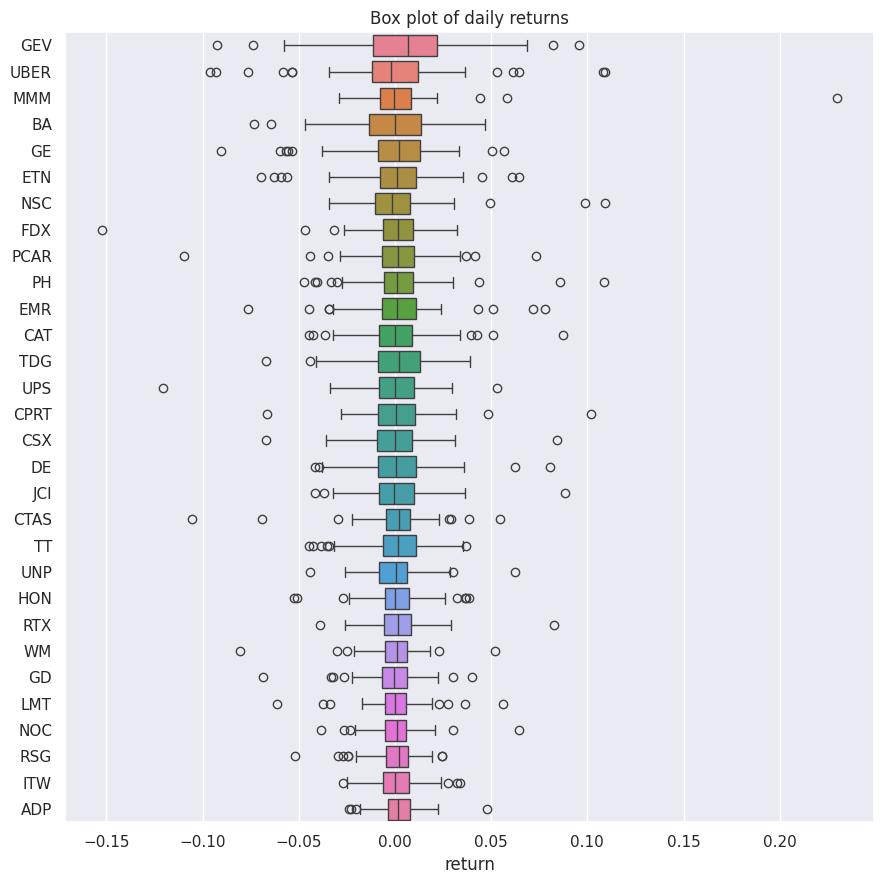

In [21]:
fig, ax1 = plt.subplots(figsize=(9, 9))
ax1=sns.boxplot(data=r_sorted_by_std, orient="h",label='returns(%)')
ax1.set_title("Box plot of daily returns")
ax1.set_xlabel('return')
ax2.set_title("Daily returns of Group 1 stocks")
plt.tight_layout()
plt.show

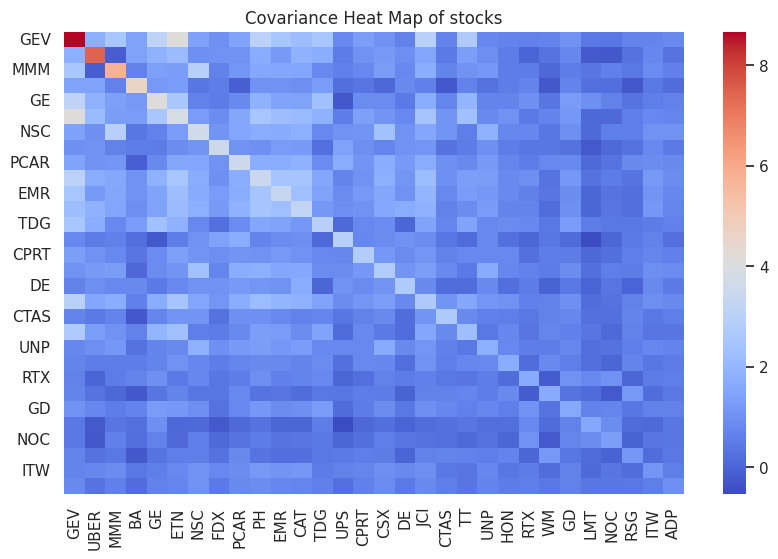

In [22]:
#Make a heatmap for covariance matrix
r_in_percentage=r_sorted_by_std*100
covariance_matrix=r_in_percentage.cov()
plt.figure(figsize=(10,6))
sns.heatmap(covariance_matrix, annot=False, cmap='coolwarm', fmt=".1f")
plt.title('Covariance Heat Map of stocks')
plt.show()

In [23]:
# standardization of daily returns
r_means=r.mean()
r_stds=r.std()
r_standardized = (r - r_means) / r_stds
print("Standardized Yield (first 2 rows):")
print(r_standardized.head(1))

Standardized Yield (first 2 rows):
                               TDG       PH  ...     CPRT      CSX
Date                                         ...                  
2024-07-02 00:00:00+00:00 1.145246 0.857323  ... 1.454151 0.317213

[1 rows x 30 columns]


In [24]:
r_standardized_cov=r_standardized.cov()

# Calculate eigenvectors and eigenvalues of the covariance matrix of standardize
eigenvalues, eigenvectors = LA.eig(r_standardized_cov)
eigenvalues

array([10.36235189,  2.78804675,  2.60452878,  2.2924989 ,  1.27318384,
        1.09783606,  1.00693573,  0.79564507,  0.78067153,  0.74234205,
        0.6939624 ,  0.65012256,  0.56377736,  0.05647529,  0.47176458,
        0.07990684,  0.10036549,  0.43414387,  0.41084545,  0.37934205,
        0.35686978,  0.14333246,  0.16403867,  0.31398101,  0.28936839,
        0.27730622,  0.25234469,  0.19170793,  0.21432508,  0.21197928])

In [25]:
#display the first eigenvectors
eigenvectors[0:1]

array([[-0.19632955, -0.24701747,  0.1768846 ,  0.02834491, -0.11406215,
         0.14526276,  0.0264377 , -0.14337742,  0.17280304, -0.01170626,
         0.04951363,  0.39023651, -0.05509714, -0.16568431,  0.17048396,
        -0.01768503,  0.07636883,  0.20210755, -0.17806163, -0.13797438,
         0.11576788, -0.20579163,  0.26138204, -0.08927035,  0.19298201,
         0.36579393, -0.2749363 , -0.16780204,  0.24852747, -0.04851869]])

In [26]:
#construction of index referring to principal component
list_index=[]
k=1
for i in range(30):
    a=str(k)
    a="PC"+a
    k=k+1
    list_index.append(a)
print(list_index)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30']


In [27]:
#display pricipal components
principal_components = r_standardized.dot(eigenvectors)
principal_components.columns = list_index
principal_components.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-02 00:00:00+00:00,-1.881310,-0.423040,0.377186,-0.241325,0.331762,0.211018,-0.136766,0.671545,-1.077060,-1.019857,-0.154488,0.481803,-0.316888,-0.091982,0.028476,-0.455517,0.202573,0.348028,-0.045372,0.127505,0.362296,0.005655,0.176082,0.763872,0.184284,1.338519,-0.036097,0.005728,0.081315,-0.361467
2024-07-03 00:00:00+00:00,-0.607202,-0.473532,1.037438,0.394408,0.579394,-0.358718,0.725152,-0.289019,0.730092,0.748818,0.048241,-0.295954,0.046824,0.146609,0.332329,0.082272,0.201459,-0.149280,0.192747,0.134107,-0.329972,0.143424,-0.038462,0.735075,0.114340,-0.151464,-0.245530,-0.230402,-0.108089,0.756975


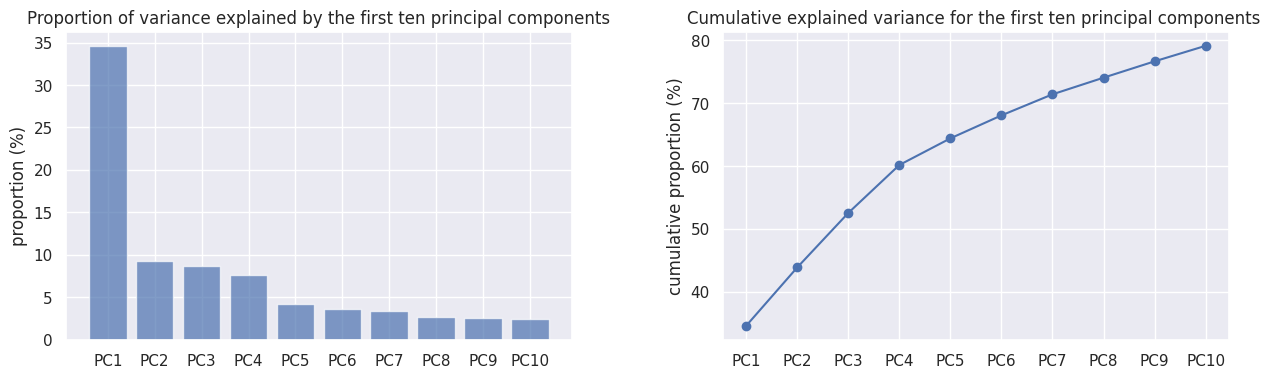

In [28]:
# Put data into a DataFrame
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues}, index=list_index)

# Work out explained proportion and cumulative proportion
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"]*100 / np.sum(df_eigval["Eigenvalues"])
cumulative=df_eigval["Explained proportion"].cumsum()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
ax1.bar(df_eigval.index[0:10],height =df_eigval["Explained proportion"].iloc[0:10] ,alpha = 0.7)
ax1.set_title("Proportion of variance explained by the first ten principal components")
ax1.set_ylabel("proportion (%)")
ax2.plot(cumulative.index[0:10],cumulative.iloc[0:10].values, marker='o', linestyle='-', label='eigenvalues cumulative curve') # Make sure you
ax2.set_title("Cumulative explained variance for the first ten principal components ")
ax2.set_ylabel("cumulative proportion (%)")
fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


In [29]:
# Perform SVD for stock returns
U, s, VT = np.linalg.svd(r_standardized_cov)

print(s)


[10.36235189  2.78804675  2.60452878  2.2924989   1.27318384  1.09783606
  1.00693573  0.79564507  0.78067153  0.74234205  0.6939624   0.65012256
  0.56377736  0.47176458  0.43414387  0.41084545  0.37934205  0.35686978
  0.31398101  0.28936839  0.27730622  0.25234469  0.21432508  0.21197928
  0.19170793  0.16403867  0.14333246  0.10036549  0.07990684  0.05647529]


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']


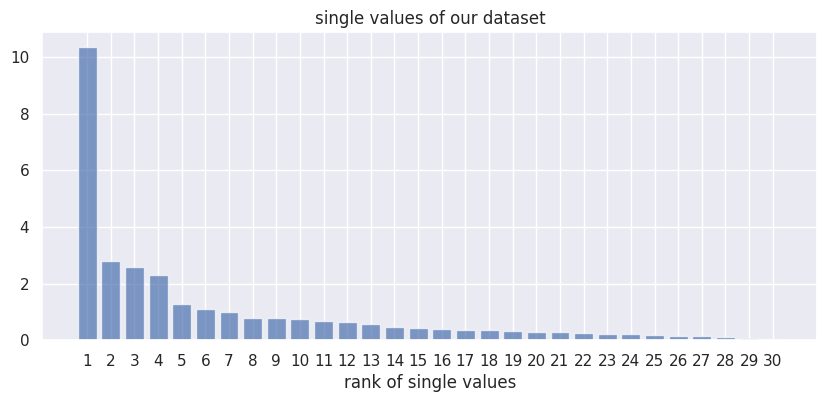

In [30]:
list_index2=[]
k=1
for i in range(30):
    a=str(k)
    k=k+1
    list_index2.append(a)
print(list_index2)



df_single_values=pd.DataFrame({"Single_values":s}, index=list_index2)
fig, ax= plt.subplots(1,1,figsize=(10,4))
ax.bar(df_single_values.index,height =df_single_values["Single_values"] ,alpha = 0.7)
ax.set_title("single values of our dataset")
ax.set_xlabel("rank of single values")
plt.show()

Text(0.5, 0, 'rank of squared single values/Eigenvalues')

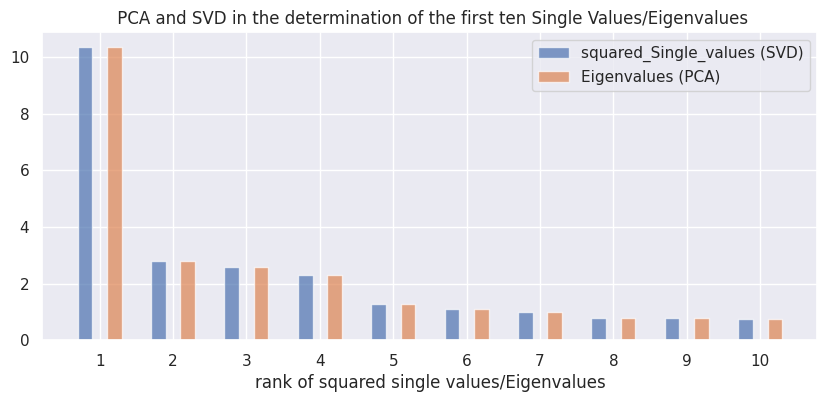

In [31]:
B=(r_standardized/math.sqrt(len(r_standardized)-1))
U, s, VT = np.linalg.svd(B)

square_of_single_values=np.square(s)
df_comparative=pd.DataFrame({"squared_Single_values":square_of_single_values,"Eigenvalues":eigenvalues} , index=list_index2)
df_comparative=df_comparative.iloc[0:10,:]
bar_width=0.4
x=np.arange(len(df_comparative))
fig, ax= plt.subplots(1,1,figsize=(10,4))
ax.bar(x-bar_width/2,df_comparative["squared_Single_values"] ,bar_width/2,label="squared_Single_values (SVD)", alpha = 0.7)
ax.bar(x+bar_width/2,df_comparative["Eigenvalues"] ,bar_width/2,label="Eigenvalues (PCA)", alpha = 0.7)
ax.set_xticks(x,df_comparative.index)
ax.legend()
ax.set_title(" PCA and SVD in the determination of the first ten Single Values/Eigenvalues")
ax.set_xlabel("rank of squared single values/Eigenvalues")